# Gene Sets and Expression for Tumor vs. Normal and Tissue Classification

Use gene sets from [MSigDB](http://software.broadinstitute.org/gsea/msigdb) to both prune the number of genes/features as well as a source of pathway information to encorporate into layer design.

In [34]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.utils import class_weight


# fix random seed for reproducibility
np.random.seed(42)

In [2]:
#need my printf 
def printf(format, *values):
    print(format % values )

In [3]:
%%time
# Load samples and labels
X = pd.read_hdf("data/TcgaTargetGtex_RSEM_Hugo_norm_count.hd5", "expression")
print("X: samples={} genes={}".format(*X.shape))

Y = pd.read_table("data/TcgaTargetGTEX_phenotype.txt.gz", compression="gzip", header=0,
                      names=["id", "category", "disease", "primary_site", "sample_type", "gender", "study"],
                      sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str")
print("Y: samples={} labels={}".format(*Y.shape))

X: samples=19249 genes=58581
Y: samples=19131 labels=6
CPU times: user 280 ms, sys: 1.92 s, total: 2.2 s
Wall time: 2.61 s


In [4]:
# Sort so indexes match
X.sort_index(axis=0, inplace=True)
X.sort_index(axis=1, inplace=True)
Y.sort_index(axis=0, inplace=True)

# Remove rows where the class is null or the sample is missing
intersection = X.index.intersection(Y[pd.notnull(Y["primary_site"])].index)
X = X[X.index.isin(intersection)]
Y = Y[Y.index.isin(intersection)]

# Make sure the label and example samples are in the same order
assert(X.index.equals(Y.index))

print(intersection.shape[0], "samples with non-null labels")

19115 samples with non-null labels


In [5]:
# Compute and add a tumor/normal column - TCGA and TARGET have some normal samples, GTEX is all normal.
Y.loc[:, "tumor_normal"] = Y.apply(
    lambda row: "Normal" if row["sample_type"] in ["Cell Line", "Normal Tissue", "Solid Tissue Normal"]
    else "Tumor", axis=1)

# Convert tumor_normal and primary_site into numerical values for two-hot multi-class training
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(encoder.fit_transform(Y["tumor_normal"]), index=Y.index)
encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(encoder.fit_transform(Y["primary_site"]), index=Y.index)
Y.describe(include="all", percentiles=[])

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
count,19115,19115,19115,19115,18957,19115,19115,19115.000000,19115.000000
unique,93,93,46,16,2,3,2,NaN,NaN
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor,NaN,NaN
freq,1212,1212,1835,9185,10447,10534,10530,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550876,20.659273
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497418,12.419497
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,19.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,45.000000


In [6]:
# Convert classes into numbers
encoder.fit(Y["primary_site"].values)
classes = encoder.transform(Y["primary_site"])
print("Total classes for stratification:", len(set(classes)))
class_labels = encoder.classes_
print(class_labels)

Total classes for stratification: 46
['Adipose Tissue' 'Adrenal Gland' 'Adrenal gland' 'Bile duct' 'Bladder'
 'Blood' 'Blood Vessel' 'Bone Marrow' 'Brain' 'Breast' 'Cervix'
 'Cervix Uteri' 'Colon' 'Endometrium' 'Esophagus' 'Eye' 'Fallopian Tube'
 'Head and Neck region' 'Heart' 'Kidney' 'Lining of body cavities' 'Liver'
 'Lung' 'Lymphatic tissue' 'Muscle' 'Nerve' 'Ovary' 'Pancreas'
 'Paraganglia' 'Pituitary' 'Prostate' 'Rectum' 'Salivary Gland' 'Skin'
 'Small Intestine' 'Soft tissue,Bone' 'Spleen' 'Stomach'
 'SympatheticÊNervous System' 'Testis' 'Thymus' 'Thyroid' 'Thyroid Gland'
 'Uterus' 'Vagina' 'White blood cell']


In [7]:
X[0:20000:3000].head()

sample,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,0.0,0.0,0.0,7.3524,6.1269,1.9343,14.432300,6.5937,4.6431,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
GTEX-145LS-1226-SM-5Q5D9,0.0,0.0,0.0,6.4274,6.8759,1.0336,18.091999,6.6323,2.0501,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
GTEX-X8HC-0126-SM-4E3JW,0.0,0.0,0.0,7.1905,7.3925,1.8230,13.508500,4.3042,11.9234,1.823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1821,0.0000
TCGA-24-1436-01,0.0,0.0,0.0,7.8777,8.3273,0.0000,14.739500,6.5108,5.7128,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1.6946
TCGA-BG-A3PP-01,0.0,0.0,0.0,5.4354,5.4573,0.0000,13.103800,5.9861,7.4694,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000


In [8]:
Y[0:20000:3000].head()

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
id,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal,0,0
GTEX-145LS-1226-SM-5Q5D9,Lung,Lung,Lung,Normal Tissue,Female,GTEX,Normal,0,22
GTEX-X8HC-0126-SM-4E3JW,Skin - Sun Exposed (Lower Leg),Skin - Sun Exposed (Lower Leg),Skin,Normal Tissue,Female,GTEX,Normal,0,33
TCGA-24-1436-01,Ovarian Serous Cystadenocarcinoma,Ovarian Serous Cystadenocarcinoma,Ovary,Primary Tumor,Female,TCGA,Tumor,1,26
TCGA-BG-A3PP-01,Uterine Corpus Endometrioid Carcinoma,Uterine Corpus Endometrioid Carcinoma,Endometrium,Primary Tumor,Female,TCGA,Tumor,1,13


In [9]:
print ('X shape', X.shape)
print (X.columns[0:10])
genes=np.array (X.columns[:])
print (genes[0:10])
print( type(genes))

X shape (19115, 58581)
Index(['5S_rRNA', '5_8S_rRNA', '7SK', 'A1BG', 'A1BG-AS1', 'A1CF', 'A2M',
       'A2M-AS1', 'A2ML1', 'A2ML1-AS1'],
      dtype='object', name='sample')
['5S_rRNA' '5_8S_rRNA' '7SK' 'A1BG' 'A1BG-AS1' 'A1CF' 'A2M' 'A2M-AS1'
 'A2ML1' 'A2ML1-AS1']
<class 'numpy.ndarray'>


In [10]:
# Load gene sets from downloaded MSigDB gmt file (KEGG to for now as its experimental vs. computational)
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    gene_sets = { line.strip().split("\t")[0]: line.strip().split("\t")[2:] for line in f.readlines()}
print("Loaded {} gene sets".format(len(gene_sets)))

# Drop any genes that are not in X
gene_sets = {name: sorted([gene for gene in genes if gene in X.columns.values]) 
             for name, genes in gene_sets.items()}

# Find the union of all gene's in the gene sets in order to filter our input rows
all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
print("Subsetting to {} genes".format(len(all_gene_set_genes)))

# Prune X to only include genes in the gene sets
X_pruned = X.drop(labels=(set(X.columns) - set(all_gene_set_genes)), axis=1, errors="ignore")
assert X_pruned["TP53"]["TCGA-ZP-A9D4-01"] == X["TP53"]["TCGA-ZP-A9D4-01"]
print("X_pruned shape", X_pruned.shape)

Loaded 186 gene sets
Subsetting to 5172 genes
X_pruned shape (19115, 5172)


In [11]:
# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(X_pruned.columns.values)
assert list(X_pruned.columns.values) == all_gene_set_genes

In [12]:
# Create a multi-class one hot output with tumor/normal + primary site
from keras.utils import np_utils
primary_site_one_hot = np_utils.to_categorical(Y["primary_site_value"])
tumor_normal_one_hot = Y["tumor_normal_value"]
Y_multiclass_onehot = np.append(
    tumor_normal_one_hot.values.reshape(tumor_normal_one_hot.shape[0],-1), 
    primary_site_one_hot, axis=1)
print(Y_multiclass_onehot.shape)
print(Y_multiclass_onehot)


(19115, 47)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [13]:
# create expanded onehot with cell, plus tumor celltype

Y_celltumor = Y["primary_site_value"] + Y["tumor_normal_value"]*46
Y_celltumor_onehot = np_utils.to_categorical(Y_celltumor)
print(Y_celltumor[0:10])
print(Y_celltumor_onehot.shape)
print(Y_celltumor_onehot[0:10])
#print(Y["primary_site_value"])


id
GTEX-1117F-0226-SM-5GZZ7     0
GTEX-1117F-0426-SM-5EGHI    24
GTEX-1117F-0526-SM-5EGHJ     6
GTEX-1117F-0626-SM-5N9CS     6
GTEX-1117F-0726-SM-5GIEN    18
GTEX-1117F-1326-SM-5EGHH     0
GTEX-1117F-2226-SM-5N9CH    26
GTEX-1117F-2426-SM-5EGGH    43
GTEX-1117F-2826-SM-5GZXL     9
GTEX-1117F-3026-SM-5GZYU    32
dtype: int64
(19115, 92)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [17]:
if(1) :  ## Expanded Data - 92 cell types
    # Split into stratified training and test sets based on classes (i.e. tissue type) so that we have equal
    # proportions of each tissue type in the train and test sets
    for train_index, test_index in split.split(X_pruned.values, Y["tumor_normal_value"]):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = Y_celltumor_onehot[train_index], Y_celltumor_onehot[test_index]
#        classes_train, classes_test = Y_celltumor[train_index], Y_celltumor[test_index]
        Y_train, Y_test = Y_celltumor[train_index].values, Y_celltumor[test_index].values
        
    print(X_train.shape, X_test.shape)
    print(y_train.shape, y_test.shape)
    print(Y_train.shape, Y_test.shape)
    
    

(15292, 58581) (3823, 58581)
(15292, 92) (3823, 92)
(15292,) (3823,)


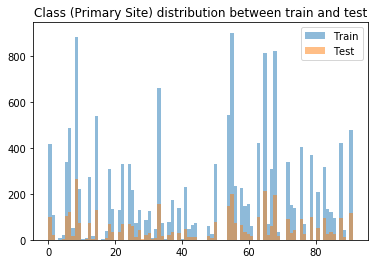

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.hist(Y_train, 92, alpha=0.5, label='Train')
plt.hist(Y_test,  92, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Class (Primary Site) distribution between train and test")
plt.show()

## Select pathway genes for weight regularization

In [20]:
## Use gene set to select for pathways
#gene_sets = {name: sorted([gene for gene in genes if gene in X.columns.values]) 
#             for name, genes in gene_sets.items()}

gene_keys=gene_sets.keys()
gene_sets['KEGG_GLYCOLYSIS_GLUCONEOGENESIS']

for k,v in gene_sets.items() :
    print(k,v[:10])

KEGG_GLYCOLYSIS_GLUCONEOGENESIS ['ACSS1', 'ACSS2', 'ADH1A', 'ADH1B', 'ADH1C', 'ADH4', 'ADH5', 'ADH6', 'ADH7', 'AKR1A1']
KEGG_CITRATE_CYCLE_TCA_CYCLE ['ACLY', 'ACO1', 'ACO2', 'CS', 'DLAT', 'DLD', 'DLST', 'FH', 'IDH1', 'IDH2']
KEGG_PENTOSE_PHOSPHATE_PATHWAY ['ALDOA', 'ALDOB', 'ALDOC', 'DERA', 'FBP1', 'FBP2', 'G6PD', 'GPI', 'H6PD', 'PFKL']
KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS ['AKR1B1', 'CRYL1', 'DCXR', 'DHDH', 'GUSB', 'RPE', 'UGDH', 'UGP2', 'UGT1A1', 'UGT1A10']
KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM ['AKR1B1', 'AKR1B10', 'ALDOA', 'ALDOB', 'ALDOC', 'FBP1', 'FBP2', 'FPGT', 'FUK', 'GMDS']
KEGG_GALACTOSE_METABOLISM ['AKR1B1', 'B4GALT1', 'B4GALT2', 'G6PC', 'G6PC2', 'GAA', 'GALE', 'GALK1', 'GALK2', 'GALT']
KEGG_ASCORBATE_AND_ALDARATE_METABOLISM ['ALDH1B1', 'ALDH2', 'ALDH3A2', 'ALDH7A1', 'ALDH9A1', 'MIOX', 'UGDH', 'UGT1A1', 'UGT1A10', 'UGT1A3']
KEGG_FATTY_ACID_METABOLISM ['ACAA1', 'ACAA2', 'ACADL', 'ACADM', 'ACADS', 'ACADSB', 'ACADVL', 'ACAT1', 'ACAT2', 'ACOX1']
KEGG_STEROID_BIOSYNTHESIS

In [21]:
#all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))



In [23]:
#read genes pathways in array
# use to create regulation pattern, penalizing weights not in pathway
print("genes:", genes.shape, genes[1:10])

#Assign pathways to weights array
paths= pd.read_table("/home/brad/Downloads/c6.all.v6.1.symbols.gmt"
                     , sep='\t'
                     , header=None
                     , names=range(1000)
                      )
#for each path, mark each weight in neuron with a one if included in pathway
npaths=188 
ngenes = X_train.shape[1]

reg_path = np.zeros((ngenes,npaths))


#for path in range(npaths) :
path=0
for key,pathgenes in gene_sets.items() :
    printf("\npath %s \n %s: ", key, pathgenes)
    for pgene in pathgenes :
        #printf( pgene )
        for w in range (ngenes) :
            #print(genes[w])
            if genes[w] == pgene :
                #printf( 'found gene=%12s, path=%4d w=%5d', genes[w],path,  w )
                reg_path[w,path]=1
    path+=1


reg_path1=np.logical_not(reg_path)+0

#print( reg_path.shape, reg_path)               
#pathcol=paths[0]
#print("paths:",patha.shape,pathcol[1])
#paths.info()


genes: (58581,) ['5_8S_rRNA' '7SK' 'A1BG' 'A1BG-AS1' 'A1CF' 'A2M' 'A2M-AS1' 'A2ML1'
 'A2ML1-AS1']

path KEGG_GLYCOLYSIS_GLUCONEOGENESIS 
 ['ACSS1', 'ACSS2', 'ADH1A', 'ADH1B', 'ADH1C', 'ADH4', 'ADH5', 'ADH6', 'ADH7', 'AKR1A1', 'ALDH1A3', 'ALDH1B1', 'ALDH2', 'ALDH3A1', 'ALDH3A2', 'ALDH3B1', 'ALDH3B2', 'ALDH7A1', 'ALDH9A1', 'ALDOA', 'ALDOB', 'ALDOC', 'BPGM', 'DLAT', 'DLD', 'ENO1', 'ENO2', 'ENO3', 'FBP1', 'FBP2', 'G6PC', 'G6PC2', 'GALM', 'GAPDH', 'GCK', 'GPI', 'HK1', 'HK2', 'HK3', 'LDHA', 'LDHAL6A', 'LDHAL6B', 'LDHB', 'LDHC', 'PCK1', 'PCK2', 'PDHA1', 'PDHA2', 'PDHB', 'PFKL', 'PFKM', 'PFKP', 'PGAM1', 'PGAM2', 'PGAM4', 'PGK1', 'PGK2', 'PGM1', 'PGM2', 'PKLR', 'TPI1']: 

path KEGG_CITRATE_CYCLE_TCA_CYCLE 
 ['ACLY', 'ACO1', 'ACO2', 'CS', 'DLAT', 'DLD', 'DLST', 'FH', 'IDH1', 'IDH2', 'IDH3A', 'IDH3B', 'IDH3G', 'MDH1', 'MDH2', 'OGDH', 'OGDHL', 'PC', 'PCK1', 'PCK2', 'PDHA1', 'PDHA2', 'PDHB', 'SDHA', 'SDHB', 'SDHC', 'SDHD', 'SUCLA2', 'SUCLG1', 'SUCLG2']: 

path KEGG_PENTOSE_PHOSPHATE_PATHWAY 
 ['ALD


path KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION 
 ['ABAT', 'ACAA1', 'ACAA2', 'ACAD8', 'ACADM', 'ACADS', 'ACADSB', 'ACAT1', 'ACAT2', 'ALDH1B1', 'ALDH2', 'ALDH3A2', 'ALDH6A1', 'ALDH7A1', 'ALDH9A1', 'AOX1', 'AUH', 'BCAT1', 'BCAT2', 'BCKDHA', 'BCKDHB', 'DBT', 'DLD', 'ECHS1', 'EHHADH', 'HADH', 'HADHA', 'HADHB', 'HIBADH', 'HIBCH', 'HMGCL', 'HMGCS1', 'HMGCS2', 'HSD17B10', 'IL4I1', 'IVD', 'MCCC1', 'MCCC2', 'MCEE', 'MUT', 'OXCT1', 'OXCT2', 'PCCA', 'PCCB']: 

path KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_BIOSYNTHESIS 
 ['BCAT1', 'BCAT2', 'IARS', 'IARS2', 'LARS', 'LARS2', 'PDHA1', 'PDHA2', 'PDHB', 'VARS', 'VARS2']: 

path KEGG_LYSINE_DEGRADATION 
 ['AADAT', 'AASDH', 'AASDHPPT', 'AASS', 'ACAT1', 'ACAT2', 'ALDH1B1', 'ALDH2', 'ALDH3A2', 'ALDH7A1', 'ALDH9A1', 'ASH1L', 'BBOX1', 'DLST', 'DOT1L', 'ECHS1', 'EHHADH', 'EHMT1', 'EHMT2', 'GCDH', 'HADH', 'HADHA', 'NSD1', 'OGDH', 'OGDHL', 'PIPOX', 'PLOD1', 'PLOD2', 'PLOD3', 'SETD1A', 'SETD1B', 'SETD2', 'SETD7', 'SETD8', 'SETDB1', 'SETDB2', 'SETMAR', 'SUV39H1', 


path KEGG_ETHER_LIPID_METABOLISM 
 ['AGPS', 'CHPT1', 'ENPP2', 'ENPP6', 'JMJD7-PLA2G4B', 'LPCAT1', 'LPCAT2', 'LPCAT4', 'PAFAH1B1', 'PAFAH1B2', 'PAFAH1B3', 'PAFAH2', 'PLA2G10', 'PLA2G12A', 'PLA2G12B', 'PLA2G1B', 'PLA2G2A', 'PLA2G2C', 'PLA2G2D', 'PLA2G2E', 'PLA2G2F', 'PLA2G3', 'PLA2G4A', 'PLA2G4B', 'PLA2G4E', 'PLA2G5', 'PLA2G6', 'PLA2G7', 'PLD1', 'PLD2', 'PPAP2A', 'PPAP2B', 'PPAP2C']: 

path KEGG_ARACHIDONIC_ACID_METABOLISM 
 ['AKR1C3', 'ALOX12', 'ALOX12B', 'ALOX15', 'ALOX15B', 'ALOX5', 'CBR1', 'CBR3', 'CYP2B6', 'CYP2C18', 'CYP2C19', 'CYP2C8', 'CYP2C9', 'CYP2E1', 'CYP2J2', 'CYP2U1', 'CYP4A11', 'CYP4A22', 'CYP4F2', 'CYP4F3', 'EPHX2', 'GGT1', 'GGT5', 'GGT6', 'GGT7', 'GPX1', 'GPX2', 'GPX3', 'GPX4', 'GPX5', 'GPX6', 'GPX7', 'HPGDS', 'JMJD7-PLA2G4B', 'LTA4H', 'LTC4S', 'PLA2G10', 'PLA2G12A', 'PLA2G12B', 'PLA2G1B', 'PLA2G2A', 'PLA2G2C', 'PLA2G2D', 'PLA2G2E', 'PLA2G2F', 'PLA2G3', 'PLA2G4A', 'PLA2G4B', 'PLA2G4E', 'PLA2G5', 'PLA2G6', 'PTGDS', 'PTGES', 'PTGES2', 'PTGIS', 'PTGS1', 'PTGS2', 'TBXAS1']:


path KEGG_DRUG_METABOLISM_OTHER_ENZYMES 
 ['CDA', 'CES1', 'CES2', 'CES5A', 'CYP2A13', 'CYP2A6', 'CYP2A7', 'CYP3A4', 'CYP3A43', 'CYP3A5', 'CYP3A7', 'DPYD', 'DPYS', 'GMPS', 'GUSB', 'HPRT1', 'IMPDH1', 'IMPDH2', 'ITPA', 'NAT1', 'NAT2', 'TK1', 'TK2', 'TPMT', 'TYMP', 'UCK1', 'UCK2', 'UCKL1', 'UGT1A1', 'UGT1A10', 'UGT1A3', 'UGT1A4', 'UGT1A5', 'UGT1A6', 'UGT1A7', 'UGT1A8', 'UGT1A9', 'UGT2A1', 'UGT2A3', 'UGT2B10', 'UGT2B11', 'UGT2B15', 'UGT2B17', 'UGT2B28', 'UGT2B4', 'UGT2B7', 'UMPS', 'UPB1', 'UPP1', 'UPP2', 'XDH']: 

path KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS 
 ['ACAA1', 'ACOT1', 'ACOT2', 'ACOT4', 'ACOT7', 'ACOX1', 'ACOX3', 'BAAT', 'ELOVL2', 'ELOVL5', 'ELOVL6', 'FADS1', 'FADS2', 'HADHA', 'HSD17B12', 'PECR', 'SCD', 'SCD5', 'TECR', 'YOD1']: 

path KEGG_ABC_TRANSPORTERS 
 ['ABCA1', 'ABCA10', 'ABCA12', 'ABCA13', 'ABCA2', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', 'ABCA7', 'ABCA8', 'ABCA9', 'ABCB1', 'ABCB10', 'ABCB11', 'ABCB4', 'ABCB5', 'ABCB6', 'ABCB7', 'ABCB8', 'ABCB9', 'ABCC1', 'ABCC10', 'ABCC1


path KEGG_ERBB_SIGNALING_PATHWAY 
 ['ABL1', 'ABL2', 'AKT1', 'AKT2', 'AKT3', 'ARAF', 'AREG', 'BAD', 'BRAF', 'BTC', 'CAMK2A', 'CAMK2B', 'CAMK2D', 'CAMK2G', 'CBL', 'CBLB', 'CBLC', 'CDKN1A', 'CDKN1B', 'CRK', 'CRKL', 'EGF', 'EGFR', 'EIF4EBP1', 'ELK1', 'ERBB2', 'ERBB3', 'ERBB4', 'EREG', 'GAB1', 'GRB2', 'GSK3B', 'HBEGF', 'HRAS', 'JUN', 'KRAS', 'MAP2K1', 'MAP2K2', 'MAP2K4', 'MAP2K7', 'MAPK1', 'MAPK10', 'MAPK3', 'MAPK8', 'MAPK9', 'MTOR', 'MYC', 'NCK1', 'NCK2', 'NRAS', 'NRG1', 'NRG2', 'NRG3', 'NRG4', 'PAK1', 'PAK2', 'PAK3', 'PAK4', 'PAK6', 'PAK7', 'PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'PIK3R1', 'PIK3R2', 'PIK3R3', 'PIK3R5', 'PLCG1', 'PLCG2', 'PRKCA', 'PRKCB', 'PRKCG', 'PTK2', 'RAF1', 'RPS6KB1', 'RPS6KB2', 'SHC1', 'SHC2', 'SHC3', 'SHC4', 'SOS1', 'SOS2', 'SRC', 'STAT5A', 'STAT5B', 'TGFA']: 

path KEGG_CALCIUM_SIGNALING_PATHWAY 
 ['ADCY1', 'ADCY2', 'ADCY3', 'ADCY4', 'ADCY7', 'ADCY8', 'ADCY9', 'ADORA2A', 'ADORA2B', 'ADRA1A', 'ADRA1B', 'ADRA1D', 'ADRB1', 'ADRB2', 'ADRB3', 'AGTR1', 'ATP2A1', 'ATP2A


path KEGG_CELL_CYCLE 
 ['ABL1', 'ANAPC1', 'ANAPC10', 'ANAPC11', 'ANAPC13', 'ANAPC2', 'ANAPC4', 'ANAPC5', 'ANAPC7', 'ATM', 'ATR', 'BUB1', 'BUB1B', 'BUB3', 'CCNA1', 'CCNA2', 'CCNB1', 'CCNB2', 'CCNB3', 'CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CCNE2', 'CCNH', 'CDC14A', 'CDC14B', 'CDC16', 'CDC20', 'CDC23', 'CDC25A', 'CDC25B', 'CDC25C', 'CDC26', 'CDC27', 'CDC45', 'CDC6', 'CDC7', 'CDK1', 'CDK2', 'CDK4', 'CDK6', 'CDK7', 'CDKN1A', 'CDKN1B', 'CDKN1C', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CDKN2D', 'CHEK1', 'CHEK2', 'CREBBP', 'CUL1', 'DBF4', 'E2F1', 'E2F2', 'E2F3', 'E2F4', 'E2F5', 'EP300', 'ESPL1', 'FZR1', 'GADD45A', 'GADD45B', 'GADD45G', 'GSK3B', 'HDAC1', 'HDAC2', 'MAD1L1', 'MAD2L1', 'MAD2L2', 'MCM2', 'MCM3', 'MCM4', 'MCM5', 'MCM6', 'MCM7', 'MDM2', 'MYC', 'ORC1', 'ORC2', 'ORC3', 'ORC4', 'ORC5', 'ORC6', 'PCNA', 'PKMYT1', 'PLK1', 'PRKDC', 'PTTG1', 'PTTG2', 'RAD21', 'RB1', 'RBL1', 'RBL2', 'RBX1', 'SFN', 'SKP1', 'SKP2', 'SMAD2', 'SMAD3', 'SMAD4', 'SMC1A', 'SMC1B', 'SMC3', 'STAG1', 'STAG2', 'TFDP1', 'TFDP2', '


path KEGG_MTOR_SIGNALING_PATHWAY 
 ['AKT1', 'AKT2', 'AKT3', 'BRAF', 'CAB39', 'CAB39L', 'DDIT4', 'EIF4B', 'EIF4E', 'EIF4E1B', 'EIF4E2', 'EIF4EBP1', 'FIGF', 'HIF1A', 'IGF1', 'INS', 'MAPK1', 'MAPK3', 'MLST8', 'MTOR', 'PDPK1', 'PGF', 'PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'PIK3R1', 'PIK3R2', 'PIK3R3', 'PIK3R5', 'PRKAA1', 'PRKAA2', 'RHEB', 'RICTOR', 'RPS6', 'RPS6KA1', 'RPS6KA2', 'RPS6KA3', 'RPS6KA6', 'RPS6KB1', 'RPS6KB2', 'RPTOR', 'STK11', 'STRADA', 'TSC1', 'TSC2', 'ULK1', 'ULK2', 'ULK3', 'VEGFA', 'VEGFB', 'VEGFC']: 

path KEGG_APOPTOSIS 
 ['AIFM1', 'AKT1', 'AKT2', 'AKT3', 'APAF1', 'ATM', 'BAD', 'BAX', 'BCL2', 'BCL2L1', 'BID', 'BIRC2', 'BIRC3', 'CAPN1', 'CAPN2', 'CASP10', 'CASP3', 'CASP6', 'CASP7', 'CASP8', 'CASP9', 'CFLAR', 'CHP2', 'CHUK', 'CSF2RB', 'CYCS', 'DFFA', 'DFFB', 'ENDOD1', 'ENDOG', 'EXOG', 'FADD', 'FAS', 'FASLG', 'IKBKB', 'IKBKG', 'IL1A', 'IL1B', 'IL1R1', 'IL1RAP', 'IL3', 'IL3RA', 'IRAK1', 'IRAK2', 'IRAK3', 'IRAK4', 'MAP3K14', 'MYD88', 'NFKB1', 'NFKBIA', 'NGF', 'NTRK1', 'PIK3CA


path KEGG_FOCAL_ADHESION 
 ['ACTB', 'ACTG1', 'ACTN1', 'ACTN2', 'ACTN3', 'ACTN4', 'AKT1', 'AKT2', 'AKT3', 'ARHGAP35', 'ARHGAP5', 'BAD', 'BCAR1', 'BCL2', 'BIRC2', 'BIRC3', 'BRAF', 'CAPN2', 'CAV1', 'CAV2', 'CAV3', 'CCND1', 'CCND2', 'CCND3', 'CDC42', 'CHAD', 'COL11A1', 'COL11A2', 'COL1A1', 'COL1A2', 'COL2A1', 'COL3A1', 'COL4A1', 'COL4A2', 'COL4A4', 'COL4A6', 'COL5A1', 'COL5A2', 'COL5A3', 'COL6A1', 'COL6A2', 'COL6A3', 'COL6A6', 'COMP', 'CRK', 'CRKL', 'CTNNB1', 'DIAPH1', 'DOCK1', 'EGF', 'EGFR', 'ELK1', 'ERBB2', 'FIGF', 'FLNA', 'FLNB', 'FLNC', 'FLT1', 'FLT4', 'FN1', 'FYN', 'GRB2', 'GSK3B', 'HGF', 'HRAS', 'IBSP', 'IGF1', 'IGF1R', 'ILK', 'ITGA1', 'ITGA10', 'ITGA11', 'ITGA2', 'ITGA2B', 'ITGA3', 'ITGA4', 'ITGA5', 'ITGA6', 'ITGA7', 'ITGA8', 'ITGA9', 'ITGAV', 'ITGB1', 'ITGB3', 'ITGB4', 'ITGB5', 'ITGB6', 'ITGB7', 'ITGB8', 'JUN', 'KDR', 'LAMA1', 'LAMA2', 'LAMA3', 'LAMA4', 'LAMA5', 'LAMB1', 'LAMB2', 'LAMB3', 'LAMB4', 'LAMC1', 'LAMC2', 'LAMC3', 'MAP2K1', 'MAPK1', 'MAPK10', 'MAPK3', 'MAPK8', 'MAPK9', '


path KEGG_NOD_LIKE_RECEPTOR_SIGNALING_PATHWAY 
 ['BIRC2', 'BIRC3', 'CARD18', 'CARD6', 'CARD8', 'CARD9', 'CASP1', 'CASP5', 'CASP8', 'CCL11', 'CCL13', 'CCL2', 'CCL5', 'CCL7', 'CCL8', 'CHUK', 'CXCL1', 'CXCL2', 'ERBB2IP', 'HSP90AA1', 'HSP90AB1', 'HSP90B1', 'IKBKB', 'IKBKG', 'IL18', 'IL1B', 'IL6', 'MAP3K7', 'MAPK1', 'MAPK10', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPK3', 'MAPK8', 'MAPK9', 'MEFV', 'NAIP', 'NFKB1', 'NFKBIA', 'NFKBIB', 'NLRC4', 'NLRP1', 'NLRP3', 'NOD1', 'NOD2', 'PSTPIP1', 'PYCARD', 'PYDC1', 'RELA', 'RIPK2', 'SUGT1', 'TAB1', 'TAB2', 'TAB3', 'TNF', 'TNFAIP3', 'TRAF6', 'TRIP6', 'XIAP']: 

path KEGG_RIG_I_LIKE_RECEPTOR_SIGNALING_PATHWAY 
 ['ATG12', 'ATG5', 'AZI2', 'CASP10', 'CASP8', 'CHUK', 'CXCL10', 'CYLD', 'DDX3X', 'DDX3Y', 'DDX58', 'DHX58', 'FADD', 'IFIH1', 'IFNA1', 'IFNA10', 'IFNA13', 'IFNA14', 'IFNA16', 'IFNA17', 'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'IFNB1', 'IFNE', 'IFNK', 'IFNW1', 'IKBKB', 'IKBKE', 'IKBKG', 'IL12A', 'IL12B', 'IRF3', 'IRF7', 'I


path KEGG_LEUKOCYTE_TRANSENDOTHELIAL_MIGRATION 
 ['ACTB', 'ACTG1', 'ACTN1', 'ACTN2', 'ACTN3', 'ACTN4', 'ARHGAP35', 'ARHGAP5', 'BCAR1', 'CD99', 'CDC42', 'CDH5', 'CLDN1', 'CLDN10', 'CLDN11', 'CLDN14', 'CLDN15', 'CLDN16', 'CLDN17', 'CLDN18', 'CLDN19', 'CLDN2', 'CLDN20', 'CLDN22', 'CLDN23', 'CLDN3', 'CLDN4', 'CLDN5', 'CLDN6', 'CLDN7', 'CLDN8', 'CLDN9', 'CTNNA1', 'CTNNA2', 'CTNNA3', 'CTNNB1', 'CTNND1', 'CXCL12', 'CXCR4', 'CYBA', 'CYBB', 'ESAM', 'EZR', 'F11R', 'GNAI1', 'GNAI2', 'GNAI3', 'ICAM1', 'ITGA4', 'ITGAL', 'ITGAM', 'ITGB1', 'ITGB2', 'ITK', 'JAM2', 'JAM3', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MLLT4', 'MMP2', 'MMP9', 'MSN', 'MYL10', 'MYL12A', 'MYL12B', 'MYL2', 'MYL5', 'MYL7', 'MYL9', 'MYLPF', 'NCF1', 'NCF2', 'NCF4', 'NOX1', 'NOX3', 'OCLN', 'PECAM1', 'PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'PIK3R1', 'PIK3R2', 'PIK3R3', 'PIK3R5', 'PLCG1', 'PLCG2', 'PRKCA', 'PRKCB', 'PRKCG', 'PTK2', 'PTK2B', 'PTPN11', 'PXN', 'RAC1', 'RAC2', 'RAP1A', 'RAP1B', 'RAPGEF3', 'RAPGEF4', 'RASSF5', 'RHOA', 'RH


path KEGG_REGULATION_OF_ACTIN_CYTOSKELETON 
 ['ABI2', 'ACTB', 'ACTG1', 'ACTN1', 'ACTN2', 'ACTN3', 'ACTN4', 'APC', 'APC2', 'ARAF', 'ARHGAP35', 'ARHGEF1', 'ARHGEF12', 'ARHGEF4', 'ARHGEF6', 'ARHGEF7', 'ARPC1A', 'ARPC1B', 'ARPC2', 'ARPC3', 'ARPC4', 'ARPC5', 'ARPC5L', 'BAIAP2', 'BCAR1', 'BDKRB1', 'BDKRB2', 'BRAF', 'BRK1', 'CD14', 'CDC42', 'CFL1', 'CFL2', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5', 'CRK', 'CRKL', 'CSK', 'CYFIP1', 'CYFIP2', 'DIAPH1', 'DIAPH2', 'DIAPH3', 'DOCK1', 'EGF', 'EGFR', 'ENAH', 'EZR', 'F2', 'F2R', 'FGD1', 'FGD3', 'FGF1', 'FGF10', 'FGF11', 'FGF12', 'FGF13', 'FGF14', 'FGF16', 'FGF17', 'FGF18', 'FGF19', 'FGF2', 'FGF20', 'FGF21', 'FGF22', 'FGF23', 'FGF3', 'FGF4', 'FGF5', 'FGF6', 'FGF7', 'FGF8', 'FGF9', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'FN1', 'GIT1', 'GNA12', 'GNA13', 'GNG12', 'GSN', 'HRAS', 'INS', 'INSRR', 'IQGAP1', 'IQGAP2', 'IQGAP3', 'ITGA1', 'ITGA10', 'ITGA11', 'ITGA2', 'ITGA2B', 'ITGA3', 'ITGA4', 'ITGA5', 'ITGA6', 'ITGA7', 'ITGA8', 'ITGA9', 'ITGAD', 'ITGAE', 'ITGA


path KEGG_VASOPRESSIN_REGULATED_WATER_REABSORPTION 
 ['ADCY3', 'ADCY6', 'ADCY9', 'AQP2', 'AQP3', 'AQP4', 'ARHGDIA', 'ARHGDIB', 'AVP', 'AVPR2', 'CREB1', 'CREB3', 'CREB3L1', 'CREB3L2', 'CREB3L3', 'CREB3L4', 'CREB5', 'DCTN1', 'DCTN2', 'DCTN4', 'DCTN5', 'DCTN6', 'DYNC1H1', 'DYNC1I1', 'DYNC1I2', 'DYNC1LI1', 'DYNC1LI2', 'DYNC2H1', 'DYNC2LI1', 'DYNLL1', 'DYNLL2', 'GNAS', 'NSF', 'PRKACA', 'PRKACB', 'PRKACG', 'PRKX', 'RAB11A', 'RAB11B', 'RAB5A', 'RAB5B', 'RAB5C', 'STX4', 'VAMP2']: 

path KEGG_PROXIMAL_TUBULE_BICARBONATE_RECLAMATION 
 ['AQP1', 'ATP1A1', 'ATP1A2', 'ATP1A3', 'ATP1A4', 'ATP1B1', 'ATP1B2', 'ATP1B3', 'ATP1B4', 'CA2', 'CA4', 'FXYD2', 'GLS', 'GLS2', 'GLUD1', 'GLUD2', 'MDH1', 'PCK1', 'PCK2', 'SLC25A10', 'SLC38A3', 'SLC4A4', 'SLC9A3']: 

path KEGG_ALZHEIMERS_DISEASE 
 ['ADAM10', 'ADAM17', 'APAF1', 'APBB1', 'APH1A', 'APOE', 'APP', 'ATF6', 'ATP2A1', 'ATP2A2', 'ATP2A3', 'ATP5A1', 'ATP5B', 'ATP5C1', 'ATP5D', 'ATP5E', 'ATP5F1', 'ATP5G1', 'ATP5G1P5', 'ATP5G2', 'ATP5G3', 'ATP5H', 'ATP5J', 'ATP


path KEGG_PATHWAYS_IN_CANCER 
 ['ABL1', 'AKT1', 'AKT2', 'AKT3', 'APC', 'APC2', 'APPL1', 'AR', 'ARAF', 'ARNT', 'ARNT2', 'AXIN1', 'AXIN2', 'BAD', 'BAX', 'BCL2', 'BCL2L1', 'BCR', 'BID', 'BIRC2', 'BIRC3', 'BIRC5', 'BMP2', 'BMP4', 'BRAF', 'BRCA2', 'CASP3', 'CASP8', 'CASP9', 'CBL', 'CBLB', 'CBLC', 'CCDC6', 'CCNA1', 'CCND1', 'CCNE1', 'CCNE2', 'CDC42', 'CDH1', 'CDK2', 'CDK4', 'CDK6', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CEBPA', 'CHUK', 'CKS1B', 'COL4A1', 'COL4A2', 'COL4A4', 'COL4A6', 'CREBBP', 'CRK', 'CRKL', 'CSF1R', 'CSF2RA', 'CSF3R', 'CTBP1', 'CTBP2', 'CTNNA1', 'CTNNA2', 'CTNNA3', 'CTNNB1', 'CUL2', 'CYCS', 'DAPK1', 'DAPK2', 'DAPK3', 'DCC', 'DVL1', 'DVL2', 'DVL3', 'E2F1', 'E2F2', 'E2F3', 'EGF', 'EGFR', 'EGLN1', 'EGLN2', 'EGLN3', 'EP300', 'EPAS1', 'ERBB2', 'ETS1', 'FADD', 'FAS', 'FASLG', 'FGF1', 'FGF10', 'FGF11', 'FGF12', 'FGF13', 'FGF14', 'FGF16', 'FGF17', 'FGF18', 'FGF19', 'FGF2', 'FGF20', 'FGF21', 'FGF22', 'FGF23', 'FGF3', 'FGF4', 'FGF5', 'FGF6', 'FGF7', 'FGF8', 'FGF9', 'FGFR1', 'FGFR2


path KEGG_CHRONIC_MYELOID_LEUKEMIA 
 ['ABL1', 'AKT1', 'AKT2', 'AKT3', 'ARAF', 'BAD', 'BCL2L1', 'BCR', 'BRAF', 'CBL', 'CBLB', 'CBLC', 'CCND1', 'CDK4', 'CDK6', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CHUK', 'CRK', 'CRKL', 'CTBP1', 'CTBP2', 'E2F1', 'E2F2', 'E2F3', 'GAB2', 'GRB2', 'HDAC1', 'HDAC2', 'HRAS', 'IKBKB', 'IKBKG', 'KRAS', 'MAP2K1', 'MAP2K2', 'MAPK1', 'MAPK3', 'MDM2', 'MECOM', 'MYC', 'NFKB1', 'NFKBIA', 'NRAS', 'PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'PIK3R1', 'PIK3R2', 'PIK3R3', 'PIK3R5', 'PTPN11', 'RAF1', 'RB1', 'RELA', 'RUNX1', 'SHC1', 'SHC2', 'SHC3', 'SHC4', 'SMAD3', 'SMAD4', 'SOS1', 'SOS2', 'STAT5A', 'STAT5B', 'TGFB1', 'TGFB2', 'TGFB3', 'TGFBR1', 'TGFBR2', 'TP53']: 

path KEGG_ACUTE_MYELOID_LEUKEMIA 
 ['AKT1', 'AKT2', 'AKT3', 'ARAF', 'BAD', 'BRAF', 'CCNA1', 'CCND1', 'CEBPA', 'CHUK', 'EIF4EBP1', 'FLT3', 'GRB2', 'HRAS', 'IKBKB', 'IKBKG', 'JUP', 'KIT', 'KRAS', 'LEF1', 'MAP2K1', 'MAP2K2', 'MAPK1', 'MAPK3', 'MTOR', 'MYC', 'NFKB1', 'NRAS', 'PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'PIK3R1', '


path KEGG_VIRAL_MYOCARDITIS 
 ['ABL1', 'ABL2', 'ACTB', 'ACTG1', 'BID', 'CASP3', 'CASP8', 'CASP9', 'CAV1', 'CCND1', 'CD28', 'CD40', 'CD40LG', 'CD55', 'CD80', 'CD86', 'CXADR', 'CYCS', 'DAG1', 'DMD', 'EIF4G1', 'EIF4G2', 'EIF4G3', 'FYN', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DRA', 'HLA-DRB1', 'HLA-DRB5', 'HLA-E', 'HLA-F', 'HLA-G', 'ICAM1', 'ITGAL', 'ITGB2', 'LAMA2', 'MYH1', 'MYH10', 'MYH11', 'MYH13', 'MYH14', 'MYH15', 'MYH2', 'MYH3', 'MYH4', 'MYH6', 'MYH7', 'MYH7B', 'MYH8', 'MYH9', 'PRF1', 'RAC1', 'RAC2', 'RAC3', 'SGCA', 'SGCB', 'SGCD', 'SGCG']: 


0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


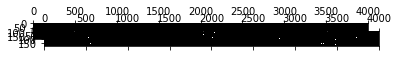

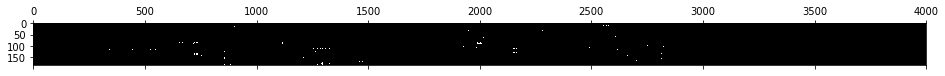

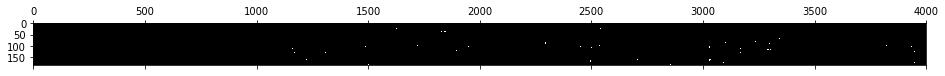

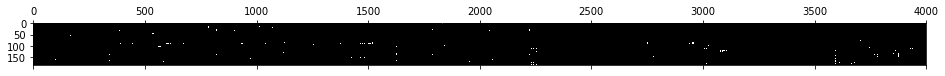

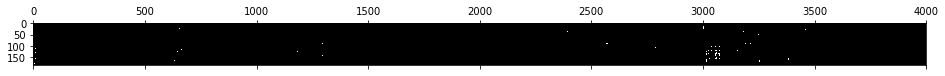

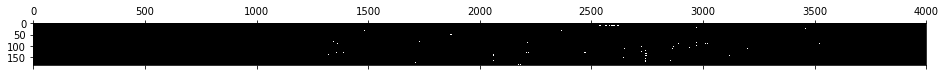

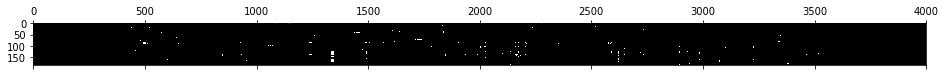

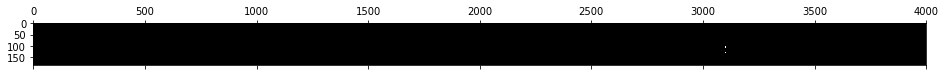

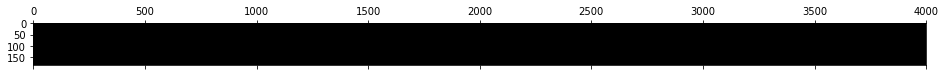

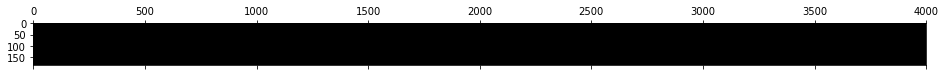

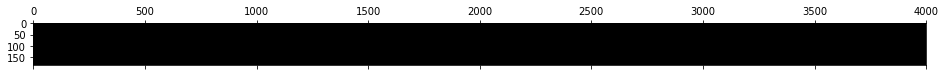

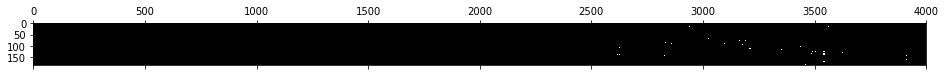

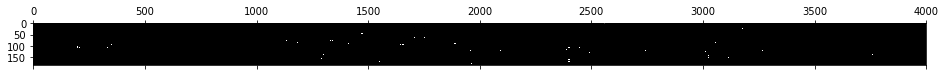

In [26]:
#Show pathways 
for i in range (14) :
    print( i*4000 )               
    plt.matshow(reg_path[i*4000 :i* 4000+4000,:].T, fignum=i, cmap='gray')


In [29]:
#add in some unconstrained neurons by tacking ones onto regpath
npaths_ex= 190
reg_path_ex = np.ones((reg_path.shape[0], npaths_ex-npaths))
print( reg_path .shape, reg_path)  
print( reg_path_ex.shape, reg_path_ex)  
#Tclasses_train=np.concatenate((yall1, yall0), axis=1)

reg_path =np.concatenate((reg_path,reg_path_ex) ,axis=1)
reg_path1=np.logical_not(reg_path)+0
print( reg_path.shape, reg_path)               


(58581, 188) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(58581, 2) [[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]
(58581, 190) [[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


In [30]:
#initialize weights, gate noise with regularize
from keras import backend as K

def path_init(shape, dtype=None):
    
    return K.random_normal(shape, dtype=dtype)*reg_path



In [31]:
# add regularization to reduce weights not in pathway

from keras import backend as K
def path_norm (weight_matrix) :
#    import numpy as np
#    val = np.random.random((1))
    var = K.variable(value=reg_path)  
#    print("123", weight_matrix.shape)
#    weight_matrix=K.print_tensor(weight_matrix, message='wtf test\n\n')
#    var=print(tf.Print(var, [tf.shape(var)]))
#    return K.sum(K.abs(var))
#    return 0.01 * K.sum(K.abs(weight_matrix*reg_path))
    reg_loss=100*K.sum(K.abs(weight_matrix*reg_path1)) 
    return (reg_loss) 

In [35]:
"""
Batch normalization with a sparse layer.

Achieves on Test:
3744/3826 [============================>.] - ETA: 0s(['loss', 'acc'], [0.52888519396363787, 0.89388395178336721])
"""
import keras
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras import regularizers

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
#opt = keras.optimizers.rmsprop(lr=0.000001, decay=1e-6)
#opt = keras.optimizers.adam()
sample_weights = class_weight.compute_sample_weight('balanced', Y_train[:])


classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    
    #Dense(npaths,kernel_regularizer=path_norm,kernel_initializer=path_init),
    Dense(npaths_ex,kernel_regularizer=path_norm,kernel_initializer=path_init),
    BatchNormalization(),
    Dropout(.5),
    Activation('selu'),

    
    Dense(200),
    BatchNormalization(),
    Dropout(.3),
    Activation('selu'),

    
    Dense(92, activity_regularizer=regularizers.l1(0.0001)),
    Activation('softmax')
]

pathmodel = Sequential(classify)
pathmodel.compile(loss='kullback_leibler_divergence', optimizer=opt, metrics=['accuracy'])

#callbacks=[ TBoard ]
pathmodel.fit(X_train, y_train, epochs=20, batch_size=128, shuffle="true", sample_weight = sample_weights, validation_data=(X_test, y_test))



Train on 15292 samples, validate on 3823 samples
Epoch 1/20
15292/15292 [==============================] - 5s 309us/step - loss: 60117.0893 - acc: 0.0251 - val_loss: 8365.2290 - val_acc: 0.1515
Epoch 2/20
15292/15292 [==============================] - 3s 201us/step - loss: 54788.5344 - acc: 0.0874 - val_loss: 9126.8070 - val_acc: 0.4340
Epoch 3/20
15292/15292 [==============================] - 3s 200us/step - loss: 54785.3027 - acc: 0.1955 - val_loss: 9526.0960 - val_acc: 0.6061
Epoch 4/20
15292/15292 [==============================] - 3s 204us/step - loss: 54780.2619 - acc: 0.3202 - val_loss: 9835.9218 - val_acc: 0.7086
Epoch 5/20
15292/15292 [==============================] - 3s 202us/step - loss: 54774.5768 - acc: 0.4183 - val_loss: 10116.5117 - val_acc: 0.7706
Epoch 6/20
15292/15292 [==============================] - 3s 203us/step - loss: 54769.0049 - acc: 0.4980 - val_loss: 10386.6682 - val_acc: 0.8077
Epoch 7/20
15292/15292 [==============================] - 3s 203us/step - loss:

In [37]:
pathmodel.fit(X_train, y_train, epochs=20, batch_size=128, shuffle="true", sample_weight = sample_weights, validation_data=(X_test, y_test))


Train on 15292 samples, validate on 3823 samples
Epoch 1/20
15292/15292 [==============================] - 3s 202us/step - loss: 54563.4669 - acc: 0.8578 - val_loss: 16256.4096 - val_acc: 0.9262
Epoch 2/20
15292/15292 [==============================] - 3s 203us/step - loss: 54557.2529 - acc: 0.8605 - val_loss: 16394.8903 - val_acc: 0.9275
Epoch 3/20
15292/15292 [==============================] - 3s 202us/step - loss: 54551.3656 - acc: 0.8619 - val_loss: 16504.5847 - val_acc: 0.9273
Epoch 4/20
15292/15292 [==============================] - 3s 201us/step - loss: 54545.3033 - acc: 0.8633 - val_loss: 16609.9718 - val_acc: 0.9283
Epoch 5/20
15292/15292 [==============================] - 3s 199us/step - loss: 54539.2062 - acc: 0.8629 - val_loss: 16762.1908 - val_acc: 0.9294
Epoch 6/20
15292/15292 [==============================] - 3s 199us/step - loss: 54533.3320 - acc: 0.8678 - val_loss: 16854.4568 - val_acc: 0.9302
Epoch 7/20
15292/15292 [==============================] - 3s 199us/step - l

## Classify Normal Cell or Tumor Cell (92 bins)


In [ ]:
    print('X_train', X_train.shape,'X_test', X_test.shape)
    print('y_train', y_train.shape, 'y_test',y_test.shape)
    print('Y_train', classes_train.shape, 'Y_test', classes_test.shape)


In [ ]:

sampleweight=True
sample_weights = class_weight.compute_sample_weight('balanced', Y_train)


In [ ]:
"""
Multi-class classification of tumor/normal + primary site with union of genes from all gene sets as input
"""
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

epochs=10
batch_size=128

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(100, activation='relu'),
    Dropout(0.5),

    Dense(100, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.5),
    
    Dense(y_train[:,:].shape[1], activation='softmax') 
]

typemodel = Sequential(classify)
print(typemodel.summary())

typemodel.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
#callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
typemodel.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle="batch",  validation_data=(X_test, y_test))

print(typemodel.metrics_names, typemodel.evaluate(X_test, y_test))

In [ ]:
typemodel.fit(X_train, y_train, epochs=50, batch_size=batch_size, shuffle="batch", validation_data=(X_test, y_test))
print(typemodel.metrics_names, typemodel.evaluate(X_test, y_test))

In [45]:
#select model to use for display

#model=typemodel
model=pathmodel
sampleweight=True



## Augment data 

In [42]:
model=pathmodel
sampleweight=True
#model=typemodel

import numpy as np
def RNA_mix(mix, naug):
    
    print( X_train.shape[0] )
    rmix=np.random.rand()*(1-mix)
    print(mix, 1-rmix)

    samples=X_train.shape[0]
    for i in range(naug) :
        i0 = np.random.randint(samples)
        i1 = np.random.randint(samples)
        X_mix0 = X_train[i0,:] *(1-rmix) 
        X_mix1 = X_train[i1,:] *(  rmix)
        
        #print(i0,i1 )
        #print(X_train[i0, 0:5] )
        #print(X_train[i1, 0:5] )
        #print(Xmix0[0:5] )
        #print(Xmix1[0:5] )
        X_aug[i,:]= X_mix0 + X_mix1
        y_aug[i,:]= y_train[i0,:]
        Y_aug[i]  = Y_train[i0]
        
naug=5000
X_aug =np.zeros((naug,X_train.shape[1]))
y_aug =np.zeros((naug,y_train.shape[1]))
Y_aug =np.zeros((naug))

#RNA_mix(.4, naug)  

for k in range(3):
    for i in range(10):
        RNA_mix(.8, naug)   
        if sampleweight :     
            sample_weights = class_weight.compute_sample_weight('balanced', Y_aug)
            model.fit(X_aug, y_aug, epochs=1, batch_size=128, shuffle="true",sample_weight = sample_weights,validation_data=(X_test, y_test))
        if not sampleweight : model.fit(X_aug, y_aug, epochs=1, batch_size=128, shuffle="true",validation_data=(X_test, y_test))

    if sampleweight :     
        sample_weights = class_weight.compute_sample_weight('balanced', Y_train)
        model.fit(X_train, y_train, epochs=10, batch_size=256, shuffle="true",sample_weight = sample_weights,validation_data=(X_test, y_test))
    if not sampleweight :     
        model.fit(X_train, y_train, epochs=10, batch_size=256, shuffle="true",validation_data=(X_test, y_test))


15292
0.8 0.8057573267917297
Train on 5000 samples, validate on 3823 samples
Epoch 1/1
5000/5000 [==============================] - 2s 369us/step - loss: 53707.6309 - acc: 0.8608 - val_loss: 19389.2281 - val_acc: 0.9289
15292
0.8 0.9792083599969141
Train on 5000 samples, validate on 3823 samples
Epoch 1/1
5000/5000 [==============================] - 2s 372us/step - loss: 53705.4411 - acc: 0.8748 - val_loss: 19412.1709 - val_acc: 0.9317
15292
0.8 0.8879080281133681
Train on 5000 samples, validate on 3823 samples
Epoch 1/1
5000/5000 [==============================] - 2s 367us/step - loss: 53704.3189 - acc: 0.8742 - val_loss: 19440.2291 - val_acc: 0.9325
15292
0.8 0.9758596878969814
Train on 5000 samples, validate on 3823 samples
Epoch 1/1
5000/5000 [==============================] - 2s 373us/step - loss: 53702.9901 - acc: 0.8820 - val_loss: 19466.2147 - val_acc: 0.9325
15292
0.8 0.9273293558010645
Train on 5000 samples, validate on 3823 samples
Epoch 1/1
5000/5000 [======================

5000/5000 [==============================] - 2s 367us/step - loss: 53641.8372 - acc: 0.8852 - val_loss: 21316.6870 - val_acc: 0.9315
15292
0.8 0.9660626459901572
Train on 5000 samples, validate on 3823 samples
Epoch 1/1
5000/5000 [==============================] - 2s 366us/step - loss: 53639.1899 - acc: 0.8968 - val_loss: 21333.6689 - val_acc: 0.9328
15292
0.8 0.9840234694249979
Train on 5000 samples, validate on 3823 samples
Epoch 1/1
5000/5000 [==============================] - 2s 364us/step - loss: 53637.1934 - acc: 0.9016 - val_loss: 21356.0866 - val_acc: 0.9323
15292
0.8 0.861500848972567
Train on 5000 samples, validate on 3823 samples
Epoch 1/1
5000/5000 [==============================] - 2s 364us/step - loss: 53636.9451 - acc: 0.8892 - val_loss: 21360.3461 - val_acc: 0.9336
15292
0.8 0.9601072044007627
Train on 5000 samples, validate on 3823 samples
Epoch 1/1
5000/5000 [==============================] - 2s 366us/step - loss: 53634.1734 - acc: 0.9032 - val_loss: 21385.6033 - val_

# Visualize the Results

In [43]:
from   plotly.offline    import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from   sklearn.metrics   import confusion_matrix

#Matplotlib inline
%matplotlib inline

# run at the start of every ipython notebook to use plotly.offline
# this injects the plotly.js source files into the notebook
init_notebook_mode(connected=True) 


## Show the Histogram

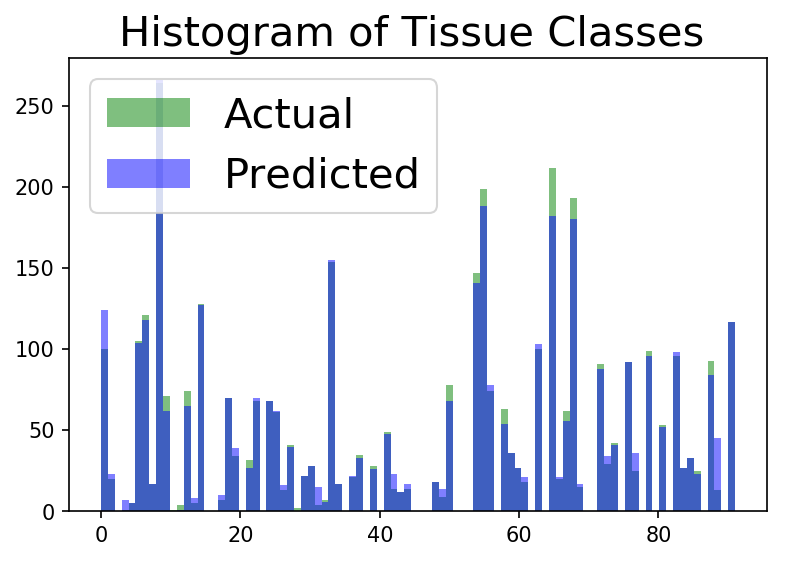

In [46]:
#
P_test =model.predict_classes( X_test) 


plt.figure(num=2, dpi=150, frameon=1)
plt.title('Histogram of Tissue Classes ',fontsize = 20)
Y_n, Ybins, Yhist = plt.hist(Y_test[:], 92, facecolor='green', alpha=0.5)
P_n, Ybins, Phist = plt.hist(P_test[:], 92, facecolor='blue',  alpha=0.5)
plt.legend((Yhist[0], Phist[0]), ('Actual', 'Predicted'),fontsize = 20)
plt.show()

#check axis
#hist_col=np.zeros(92)
#hist_row=np.zeros(92)
#
#for col in range(92) :
#    hist_col[col]    = np.sum(cm[ 0:92,col] )  
#for row in range(92) :
#    hist_row[row]    = np.sum(cm[row, 0:92] )  
#print('check row=Actual'   ,  Y_n[0:10], hist_row[0:10])
#print('check col=Predicted',  P_n[0:10], hist_col[0:10])

## Show the Confusion Matrix

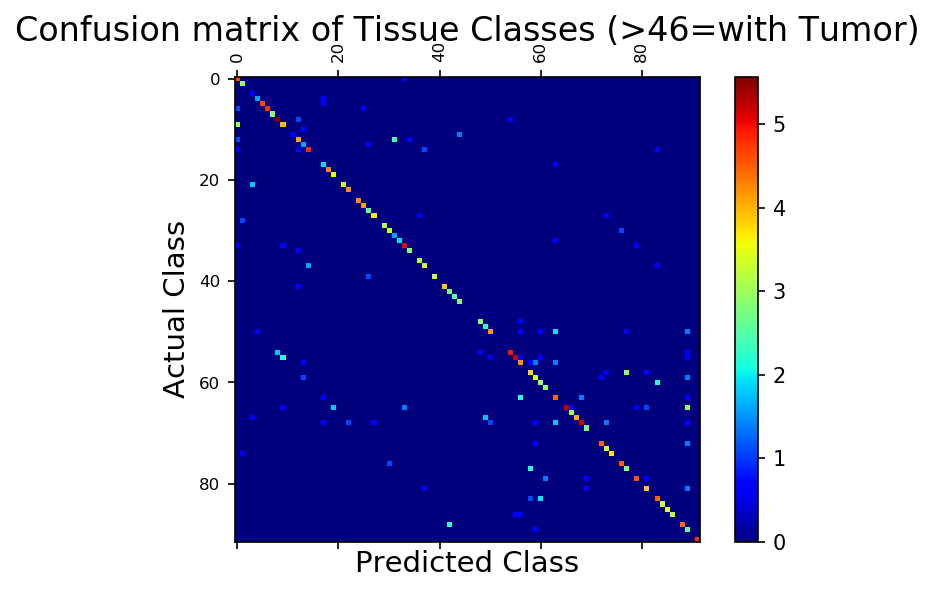

In [47]:
#import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
P_test =model.predict_classes( X_test) 

cm = confusion_matrix(Y_test[:], P_test[:], labels=np.arange(92))

plt.figure(num=1, dpi=150, frameon=1)
plt.matshow(np.log(cm+1), fignum=1, cmap='jet')
plt.title('Confusion matrix of Tissue Classes (>46=with Tumor)',fontsize = 16)
plt.xlabel('Predicted Class',fontsize = 14)
plt.ylabel('Actual Class',fontsize = 14)
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8, rotation=00)
plt.colorbar()
plt.show()

## Show Normalized Confusion matrix using Plotly 

In [48]:
labels =[      class_labels[i] for i in range(46)]
labels+=['T_'+ class_labels[i] for i in range(46)]
#print('labels =', labels)

#Normalize rows 
cmp=cm[:,:]*1.000
for row in range(92) :
    if Y_n[row] != 0 :  
        for col in range(92) :
            cmp[row, col] = cm[row,col]/Y_n[row]
        #print('Y_n', row, Y_n[row], cm [row,0:46], cmp[row,0:46])



trace = go.Heatmap(
    z=cmp,
    x=labels,
    y=labels,
    ygap=0,
    xgap=0,
    colorscale=[
        [0.0,   'rgb(  0, 30,100)'], 
        [0.01,  'rgb( 50, 50, 150)'], 
        [0.02,  'rgb( 50,100, 200)'], 
        [0.04,  'rgb(100,100, 150)'], 
        [0.1,   'rgb(250,100,100)'], 
        [0.5,   'rgb(200,250,200)'], 
        [1.0,   'rgb(255,250,255)']]
 

)
data=[trace]


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(
        l=150,
        r=100,
        b=150,
        t=100,
        pad=4
    ),
    paper_bgcolor='#ffffff',
    plot_bgcolor='#000000' ,
    title='Confusion Matrix',
    xaxis=dict(
        title='Predicted',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        )
    ),
    yaxis=dict(
        title='Actual',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        )
    )


)
fig = go.Figure(data=data, layout=layout)
plot_url = plot(fig, filename='normalized confusion-matrix.html')

iplot(data, filename='normalized confusion matrix')


## Visualize the Weights

In [49]:
model= pathmodel
model.summary()

if(1):
    x=model.get_weights()

    
    #x=get_weights()
    print("\n weight list" )
    for i in range(2) :
        print("weight", i, x[i].shape, x[i] )
    print("layers=", model.layers)
    print("inputs=", model.inputs)
    print("outputs=", model.outputs)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 58581)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 58581)             234324    
_________________________________________________________________
dense_1 (Dense)              (None, 190)               11130580  
_________________________________________________________________
batch_normalization_2 (Batch (None, 190)               760       
_________________________________________________________________
dropout_1 (Dropout)          (None, 190)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 190)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               38200     
__________

In [50]:
w=model.layers[2].get_weights()
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    #print(weights)
    
print(type(w[0]), type(w[1]), w[0].shape, w[1].shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (58581, 190) (190,)


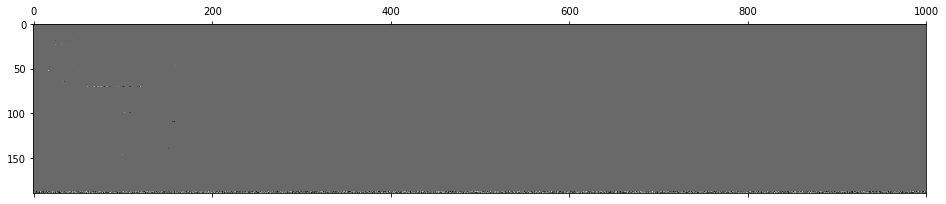

In [51]:
#show the weights

w0=w[0]
plt.matshow(w0[0:1000,:].T, fignum=1, cmap='gray')
#plt.matshow(np.log(w0[0:1000,0:].T), fignum=2, cmap='jet')


## Show the input X 

(15292, 58581)
X_sum.shape: (15292, 58581) [3.1456177 2.9157672 3.1203346 ... 3.1335475 3.069867  3.1176267]


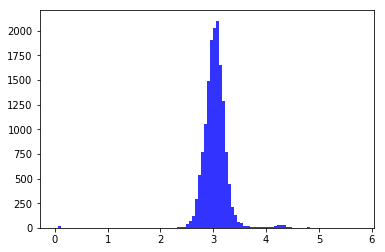

s= 0
0.0 28.1127
0.0 1.0


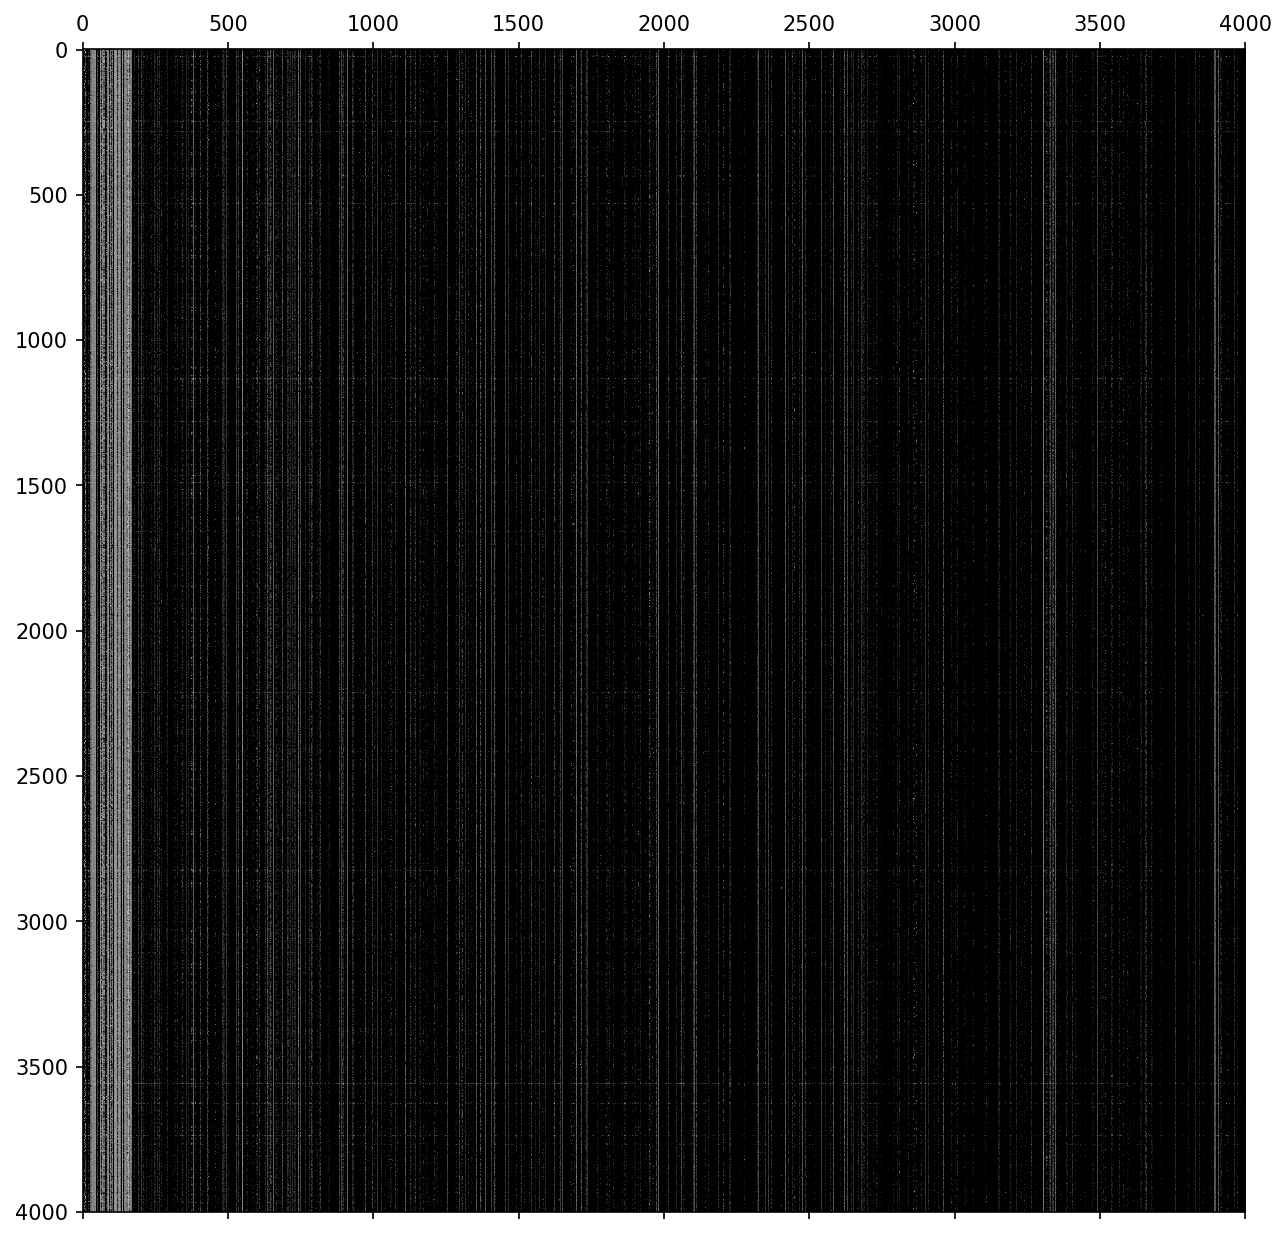

In [52]:
import matplotlib.pyplot as plt


x1=X_train[0:, 0:]
print(x1.shape)


xavg=np.average(x1, axis=1)
print("X_sum.shape:", x1.shape, xavg)
n, bins, patches = plt.hist(xavg, 100, facecolor='blue', alpha=0.8)
plt.show()


for i in range (1) :
    print('s=', i*4000)
    plt.figure(num=i+1, dpi=150, frameon=1, figsize=(10, 10))
    plt.matshow(x1[0:4000, i*4000:i*4000+4000], fignum=i+1, cmap='gray')    

smax=np.amax(x1[0:, 0:])
smin=np.amin(x1[:,:])
print(smin, smax)

x2 =(x1-smin)/(smax-smin)
smax=np.amax(x2[0:, 0:])
smin=np.amin(x2[:,:])
print(smin, smax)

x1=0
x2=0

## Show sorted input X 

set up sort

In [85]:
# Plot the raw input data as a heatmap 
# select rows and reorder matrix so similar rows and cols are next to each other


from scipy.cluster.hierarchy import dendrogram, linkage

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
#method='single' #fast (causes recursion bug in dendrogram??)
#method='complete' # very slow
#method='average' #fast
#method='weighted' #fast
method='centroid' #fast
#method='median' #fast
#method='ward' #slow


# sort and select parameters
o_samples = 0000  # row start in data 
n_samples = 3500  # number of rows
n_samples =  190  # number of rows
n_rna     = 5172  # number of rnaseqs
#n_rna     = 2000  # number of rnaseqs

o_rna     = 0     # rnaseq sstart in data
visualize = 'RNA'
visualize = 'weights'

pathway_rnas  = True
random_rnas   = True
sortrow    = True
sortcol    = True
showtest   = True
showtrain  = not showtest

# select classes to sort -- This is where we select the classes to show
class_sort  = list(range(92))
#class_sort  = list(range(0,46))
#class_sort  = [8, 46+8,]
#class_sort  = [22,23]



all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
pathway_sort = all_gene_set_genes
#pathway_sort = genes


n_classes    = len(class_sort)
printf('Select the following %d classes to sort %s:',n_classes, class_sort)
printf('Select random set %d of  %d genes in pathway to sort %s:',n_rna, len(pathway_sort), pathway_sort[0:10])



Select the following 92 classes to sort [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]:
Select random set 5172 of  5172 genes in pathway to sort ['A2M', 'A4GALT', 'AACS', 'AADAT', 'AANAT', 'AARS', 'AARS2', 'AASDH', 'AASDHPPT', 'AASS']:


In [86]:
%%time
# get predicted and actual classes and data sizes

if(showtrain==True) :
    #print('Show Training Results')
    classes_pred  = model.predict_classes( X_train)
    classes_id    = Y_train
    t_rna     = X_train.shape[1] 
    t_samples = X_train.shape[0]
        
    
if(showtest==True) :
    #print('Show Test Results')
    classes_pred  = model.predict_classes( X_test)
    classes_id    = Y_test
    t_rna     = X_test.shape[1] 
    t_samples = X_test.shape[0]


# identify the samples which contain the selected classes 

samples=[]
for k in range(n_classes) :
    for i in range (n_samples) :
        if(class_sort[k]==classes_id[i]) : 
            samples.append(i)
f_samples=len(samples)
printf('found %d samples = %s', f_samples, samples[0:8] )
print('samples\n', X_train[samples[0:4],0:8] )



# identify the gene locationas which contain the selected genes 


n_genes = len (pathway_sort)
gene_locs=[]
for k in range(n_genes) :
    for i in range (t_rna) :
        if(pathway_sort[k]==genes[i]) : 
            gene_locs.append(i)
f_genes=len(gene_locs)

printf('found %d genes = %s', f_genes, gene_locs[0:8] )
print('genes\n', X_train[samples[0:8], gene_locs[0:8] ] )

found 190 samples = [16, 33, 43, 81, 82, 92, 188, 66]
samples
 [[ 0.      0.      0.      7.8386  7.8396  0.     14.7649  7.4259]
 [ 0.      0.      0.      7.4593  6.026   5.0974 12.9321  7.6319]
 [ 0.      0.      0.      6.8247  7.0735  0.     12.2899  3.5614]
 [ 0.      0.      0.      6.2249  5.0934  3.8224 14.1862  8.1922]]
found 5172 genes = [6, 13, 17, 25, 31, 34, 35, 38]
genes
 [14.7649 11.4164 11.3224  8.3696  1.1066 14.0848 10.8303  8.1891]
CPU times: user 42.7 s, sys: 568 ms, total: 43.3 s
Wall time: 43 s


In [87]:
#add id to gene for tracking
#---------------------------------------------------------------

gene_labels=np.array([ pathway_sort[i]+'_'+ str(i)  for i in range(f_genes)])
#print('gene_labels\n',type(gene_labels ), gene_labels.shape, gene_labels [:8]  )
#print('genes\n',type(genes ), genes.shape, genes [:8]  )


In [88]:
# now select the input data for the identified samples and genes
#---------------------------------------------------------------
if(visualize=='weights') : w1=w0     [:,:].T    
if(visualize=='RNA' and showtrain==True) :     w1=X_train[samples,:]       
if(visualize=='RNA' and showtest ==True) :     w1=X_test [samples,:]       

w1=w1[:,gene_locs]    
    
print('w1\n', w1.shape,'\n', w1[0:4, 0:8]  )
    
     

w1
 (190, 5172) 
 [[ 9.8110329e-05 -9.8889177e-05  1.3427052e-06  4.5986235e-07
  -6.9914677e-08  8.1928010e-07 -5.9467129e-07  4.4720946e-07]
 [-3.4575351e-07  1.2008604e-06  3.9771621e-06  1.1422089e-06
   5.4597331e-07  1.0956937e-06  1.1922457e-06 -9.8836914e-05]
 [ 7.7788718e-07 -5.1033567e-08 -1.7802740e-06  7.3815318e-07
  -1.7570710e-07 -8.2501356e-07 -7.8340236e-07  1.2537275e-06]
 [-2.0793741e-06 -1.2323871e-06  1.9208019e-06 -1.8715800e-06
   1.5806290e-07 -5.3431722e-07  1.2769306e-08 -1.1075608e-06]]


In [89]:
#TODO add labels for pathways

In [90]:
#create the class labels
#---------------------------------------------------------------

#select subset of labels
class_pred  = classes_pred[samples]
class_id    = classes_id  [samples]
class_label=[ labels[class_id[i]]+'_'+ str(i)  for i in range(f_samples)]




# create labels with predicted and actual value if different
n_err=0 
for i in range(f_samples) :
    if(class_id[i]!=class_pred[i]) :
        class_label[i] ='Pred='+  labels[class_pred[i]] + ' True=' + class_label[i]
        n_err+=1

print()
print('act =', class_id    [0:20]    )
print('pred=', class_pred  [0:20])
printf('found %d errs in %d samples, accuracy = %2.2f', n_err, f_samples, 1-n_err/f_samples)
print('labels', class_label[0:10])


act = [0 0 0 0 0 0 0 1 3 5 5 5 5 5 5 5 5 5 6 6]
pred= [0 0 0 0 0 0 0 1 3 5 5 5 5 5 5 5 5 5 6 6]
found 13 errs in 190 samples, accuracy = 0.93
labels ['Adipose Tissue_0', 'Adipose Tissue_1', 'Adipose Tissue_2', 'Adipose Tissue_3', 'Adipose Tissue_4', 'Adipose Tissue_5', 'Adipose Tissue_6', 'Adrenal Gland_7', 'Bile duct_8', 'Blood_9']


In [91]:

# Select a window of RNA genes
if(random_rnas==False) :  
    w2 = w1[o_samples:o_samples+n_samples,o_rna:o_rna+n_rna]
    rnaseq_id=gene_labels[o_rna:n_rna+o_rna]



# Select a random subset of RNA genes
if(random_rnas==True) :
    rnas=np.random.permutation(np.arange(f_genes))
    rnas=rnas[:n_rna]
    rnaseq_id=gene_labels[rnas]
    w2 = w1[:,rnas]

print('f_genes',f_genes, 'n_rna',n_rna, 'rnas', rnas.shape, max(rnas)  )


print('rnaseq_id\n',len(rnaseq_id ), rnaseq_id [:8]  )
print('X_train\n',X_train.shape,'\n', X_train[0:4, 0:8])  
print('w1\n',w1.shape, '\n',w1[0:4, 0:8])  
print('w2\n',w2.shape, '\n',w2[0:4, 0:8])  

f_genes 5172 n_rna 5172 rnas (5172,) 5171
rnaseq_id
 5172 ['CHD8_854' 'IFIH1_2243' 'SFRP2_4362' 'PDCD6IP_3495' 'GRM6_1926'
 'ACAT1_72' 'FUT6_1663' 'CACNA1D_610']
X_train
 (15292, 58581) 
 [[ 0.      0.      0.5541  4.738   5.7813 10.0253 14.7292  5.358 ]
 [ 0.      0.      0.      5.0921  5.3596  1.7243 14.8298  7.0153]
 [ 0.      0.      0.      7.4206  7.0262  1.2041 17.462   6.6729]
 [ 0.      0.      0.      7.2152  7.7362  0.     16.0712  5.5478]]
w1
 (190, 5172) 
 [[ 9.8110329e-05 -9.8889177e-05  1.3427052e-06  4.5986235e-07
  -6.9914677e-08  8.1928010e-07 -5.9467129e-07  4.4720946e-07]
 [-3.4575351e-07  1.2008604e-06  3.9771621e-06  1.1422089e-06
   5.4597331e-07  1.0956937e-06  1.1922457e-06 -9.8836914e-05]
 [ 7.7788718e-07 -5.1033567e-08 -1.7802740e-06  7.3815318e-07
  -1.7570710e-07 -8.2501356e-07 -7.8340236e-07  1.2537275e-06]
 [-2.0793741e-06 -1.2323871e-06  1.9208019e-06 -1.8715800e-06
   1.5806290e-07 -5.3431722e-07  1.2769306e-08 -1.1075608e-06]]
w2
 (190, 5172) 
 [[ 5.1

In [92]:

#Sort matrix

if(sortrow==False) : 
    w3=w2.T
    sample_labels_permuted=[ class_label[i]  for i in range(f_samples)]

if(sortrow==True)  :
    Z = linkage(w2, method=method, optimal_ordering=True)
    dn = dendrogram(Z,no_plot=True)
    sample_leaf_order=dn['leaves']
    w3=w2[sample_leaf_order,:].T
    sample_labels_permuted=[ class_label[sample_leaf_order[i]]  for i in range(f_samples)]

    
    
print('w3\n',w3.shape,  w3[0:4, 0:4])
print('samp',len(sample_leaf_order), n_samples,'\n', sample_leaf_order[0:10], '\n',sample_labels_permuted[0:10])

#create labels for reordered samples
if(sortcol==False) :
    w4=w3.T
    rna_labels_permuted=[ rnaseq_id[i] for i in range(n_rna)]
if(sortcol==True ) :  
    Z  = linkage(w3, method=method, optimal_ordering=True)
    dn = dendrogram(Z,no_plot=True)
    rna_leaf_order=dn['leaves']
    w4 = w3[rna_leaf_order,:].T 
    rna_labels_permuted=[ rnaseq_id[rna_leaf_order[i]] for i in range(n_rna)]

print('w4\n',w4.shape,w4[0:4, 0:4])
print('rna',len(rna_leaf_order),'\n', n_rna, rna_leaf_order[0:10], '\n',rna_labels_permuted[0:10])


w3
 (5172, 190) [[ 8.6578453e-01  9.9704637e-05  5.8212754e-07  2.5611371e-09]
 [ 5.0085503e-01 -1.0032153e-04  9.8892655e-05  1.7607817e-09]
 [-1.3491614e+00  5.7751458e-07 -2.0993321e-07  9.8807359e-05]
 [-1.0494931e+00  7.4942363e-10  1.1374359e-06  3.8476719e-07]]
samp 190 190 
 [188, 138, 161, 88, 140, 112, 89, 99, 95, 114] 
 ['T_White blood cell_188', 'T_Liver_138', 'T_Prostate_161', 'T_Bladder_88', 'T_Liver_140', 'Pred=T_Head and Neck region True=T_Cervix_112', 'T_Bladder_89', 'T_Brain_99', 'T_Brain_95', 'T_Colon_114']
w4
 (190, 5172) [[-4.7378570e-01  1.0959589e+00  8.4775347e-01 -1.5118027e-01]
 [ 1.0622898e-09  9.8892233e-05  9.8892582e-05  3.4924597e-10]
 [ 1.8436372e-01 -2.4357021e+00  1.2242311e+00  4.0945113e-02]
 [-9.8360608e-05 -9.8891127e-05 -4.3655746e-11 -8.2945917e-10]]
rna 5172 
 5172 [4952, 53, 2049, 1239, 305, 4659, 3955, 1059, 3564, 1547] 
 ['MAPK3_2643', 'MAPK1_2637', 'PIK3R3_3637', 'RAF1_4044', 'CHUK_911', 'MAP2K1_2614', 'PRKACA_3842', 'SOS2_4508', 'PIK3R2_363

In [105]:
# now plot the data
#----------------------------------------------------------
if(visualize=='RNA'): # scale to 0-1
    smax=np.amax(w4[0:, 0:])
    smin=np.amin(w4[:,:])
    print('initial data range', smin, smax)
    
    w5 =(w4-smin)/(smax-smin)
    smax=np.amax(w5[0:, 0:])
    smin=np.amin(w5[:,:])
    print('scaled data range', smin, smax)
    w6=w5
    colorscale=[
        [ 0.0,  'rgb( 20, 20, 10)'], 
        [ 0.1,  'rgb( 50, 50,200)'], 
        [ 0.2,  'rgb( 50,200,200)'], 
        [ 0.4,  'rgb(200, 50, 50)'], 
        [ 0.5,  'rgb( 00, 00, 00)'], 
        [ 0.7,  'rgb(200,200, 50)'], 
        [ 0.8,  'rgb( 50,255, 50)'],
        [ 1.0,  'rgb(255,255,255)']]  
    map_title="RNA"
    xaxis_title='RNA Sequence'
    yaxis_title='Sample'



if(visualize=='weights') : #scale to +1 -1
    smax=np.amax(w4[0:, 0:])
    smin=np.amin(w4[:,:])
    print('initial data range', smin, smax)
    
    ssmax=max(smax, -smin)
    w5 =(w4)/(ssmax)/2+.5
    smax=np.amax(w5[0:, 0:])
    smin=np.amin(w5[:,:])
    print('scaled data range', smin, smax)
    w6=w5

    colorscale=[
        [ 0.0,  'rgb( 50,255, 50)'], 
        [ 0.2,  'rgb( 50,100, 50)'], 
        [ 0.3,  'rgb( 20, 50, 20)'], 
        [ 0.4,  'rgb( 10, 20, 10)'], 
        [ 0.5,  'rgb(  0,  0,  0)'], 
        [ 0.6,  'rgb( 20, 10, 10)'], 
        [ 0.7,  'rgb( 50, 20, 20)'],
        [ 0.8,  'rgb(100, 50, 50)'],
        [ 1.0,  'rgb(255, 50, 50)']]
    map_title="Layer1 Weights"
    xaxis_title='RNA Sequence'
    yaxis_title='Neuron ID'



trace = go.Heatmap(
    z=w6[0:, 0:],
    y=sample_labels_permuted,
    x=rna_labels_permuted,
    ygap=0,
    xgap=0,
    colorscale=colorscale
    )
data=[trace]


layout = go.Layout(
    autosize=False,
    width = 2000,
    height= 1000,
    margin=dict(
        l=150,
        r=100,
        b=150,
        t=100,
        pad=4
    ),
    paper_bgcolor='#ffffff',
    plot_bgcolor='#000000' ,
    title=map_title,
    xaxis=dict(
        title=xaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),
        showticklabels=True,
        tickangle=90,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
   ),
    yaxis=dict(
        #scaleanchor = "x",
        title=yaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),

        showticklabels=True,
        tickangle=0,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
    ),
)
fig = go.Figure(data=data, layout=layout)

plot_url = plot(fig, filename=map_title + '.html')

initial data range -4.1235924 3.827344
scaled data range 0.0 0.96407884
